In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
cal_df = pd.read_parquet("../validationB_v3.parquet")

In [3]:
print(train_df.shape)
print(val_df.shape)
print(cal_df.shape)

(112768, 791)
(24164, 791)
(24164, 791)


In [4]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']
X_cal = cal_df.drop(columns=['match'])
y_cal = cal_df['match']

In [5]:
X_train_raw = X_train
X_val_raw = X_val
X_test_raw = X_cal

In [6]:
for df in (X_train, X_val, X_cal):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val, X_cal):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val, X_cal):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}, X_cal: {X_cal.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789), X_cal: (24164, 789)


In [7]:
for df in (X_train, X_val, X_cal):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

Preprocessing PCA

In [8]:
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [9]:
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_cal_proc = preprocessor.transform(X_cal)

In [10]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

Custom KFold

In [11]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

In [12]:
import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

Best Models When Categorical Columns Are Excluded

In [13]:
model_1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_2 = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_3 = LogisticRegression(penalty=None, solver='lbfgs', class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

Best Models When Categorical Columns Are Included

In [14]:
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)
model_7 = RandomForestClassifier(n_estimators=300,
                                 class_weight={0:1.0, 1:250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)

Probability Calibration on Models When Categorical Columns are Excluded

Train the Models

In [15]:
# drop categorical columns
X_train_wo_cat_proc = X_train_proc.drop(columns=cat_cols)
X_val_wo_cat_proc = X_val_proc.drop(columns=cat_cols)
X_cal_wo_cat_proc = X_cal_proc.drop(columns=cat_cols)

In [16]:
# fit all the models

# models without cat_cols
model_1.fit(X_train_wo_cat_proc, y_train)
model_2.fit(X_train_wo_cat_proc, y_train)
model_3.fit(X_train_wo_cat_proc, y_train)

# models with cat_cols
model_4.fit(X_train_proc, y_train)
model_5.fit(X_train_proc, y_train)
model_6.fit(X_train_proc, y_train)
model_7.fit(X_train_proc, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomForestClassifier(class_weight={0: 1.0, 1: 250.0}, max_depth=5,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=300, random_state=42)

We Will Start With Model 4, 5 and 6

In [17]:
from sklearn.calibration import CalibratedClassifierCV

# wrap already-fitted model 
cal_model_4 = CalibratedClassifierCV(estimator=model_4, method='sigmoid', cv='prefit')
cal_model_5 = CalibratedClassifierCV(estimator=model_5, method='sigmoid', cv='prefit')
cal_model_6 = CalibratedClassifierCV(estimator=model_6, method='sigmoid', cv='prefit')

# fit calibration model on calibration set
cal_model_4.fit(X_cal_proc, y_cal)
cal_model_5.fit(X_cal_proc, y_cal)
cal_model_6.fit(X_cal_proc, y_cal)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(class_weight={0: 1, 1: 400},
                                                    max_iter=1000,
                                                    random_state=42))

In [18]:
# predict calibrated probabilities
y_cal_probs_4 = cal_model_4.predict_proba(X_cal_proc)[:, 1]
y_cal_probs_5 = cal_model_5.predict_proba(X_cal_proc)[:, 1]
y_cal_probs_6 = cal_model_6.predict_proba(X_cal_proc)[:, 1]

# predict train probability
y_train_probs_4 = model_4.predict_proba(X_train_proc)[:, 1]
y_train_probs_5 = model_5.predict_proba(X_train_proc)[:, 1]
y_train_probs_6 = model_6.predict_proba(X_train_proc)[:, 1]


### Model 4 Probability Calibration

In [20]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, roc_auc_score
import seaborn as sns

In [ ]:
threshold = 0.02  
y_proba = cal_model_4.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.96     24000
           1       0.04      0.42      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.68      0.52     24164
weighted avg       0.99      0.93      0.96     24164



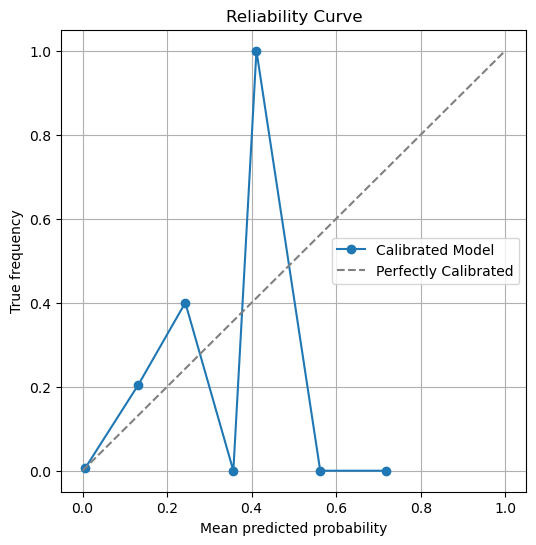

In [110]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_4, n_bins=10, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [72]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_4)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0003


In [ ]:
# Calibrated probs for train and test
p_train = cal_model_4.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_4.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
rare_indices_pct = np.where(p_test > threshold_n)[0]

print(f"# Rare events based on our threshold: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# Rare events based on our threshold: 1616


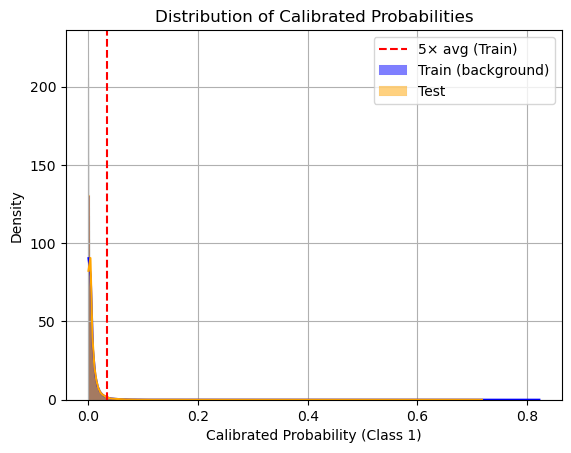

In [ ]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


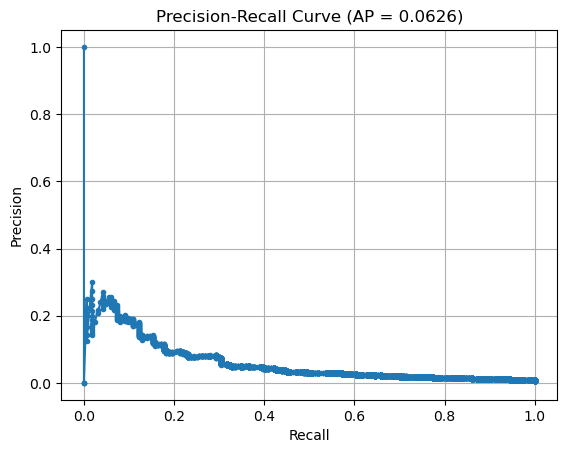

In [76]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


## Model 5

In [79]:
threshold = 0.02  # or use your 5× avg line
y_proba = cal_model_5.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24000
           1       0.04      0.41      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.67      0.52     24164
weighted avg       0.99      0.93      0.96     24164



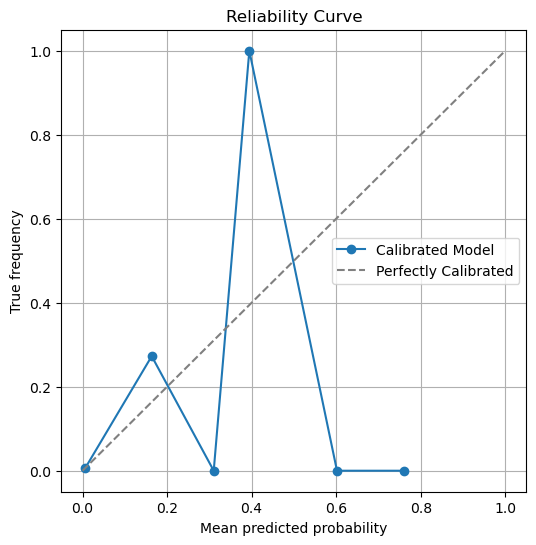

In [81]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_5, n_bins=8, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [82]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_5)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0003


In [84]:
# Calibrated probs for train and test
p_train = cal_model_5.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_5.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
rare_indices_pct = np.where(p_test > threshold_pct)[0]

print(f"# events > 5× avg: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# events > 5× avg: 600
# events > 99.9 percentile: 27


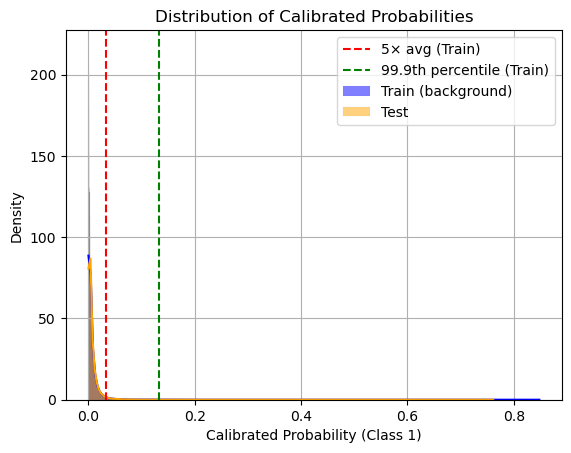

In [86]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


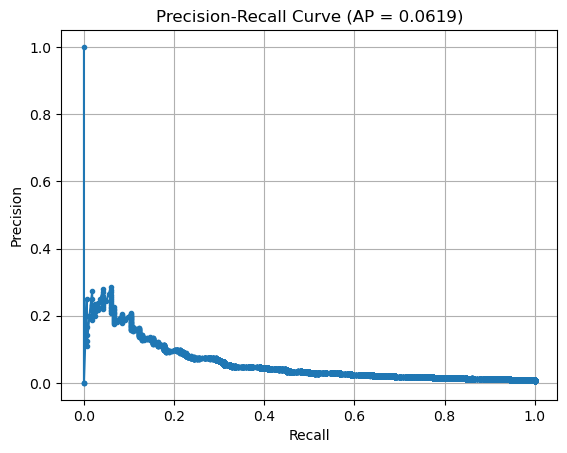

In [87]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


## Model 6

In [92]:
threshold = 0.02
y_proba = cal_model_6.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24000
           1       0.04      0.41      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.68      0.52     24164
weighted avg       0.99      0.93      0.96     24164



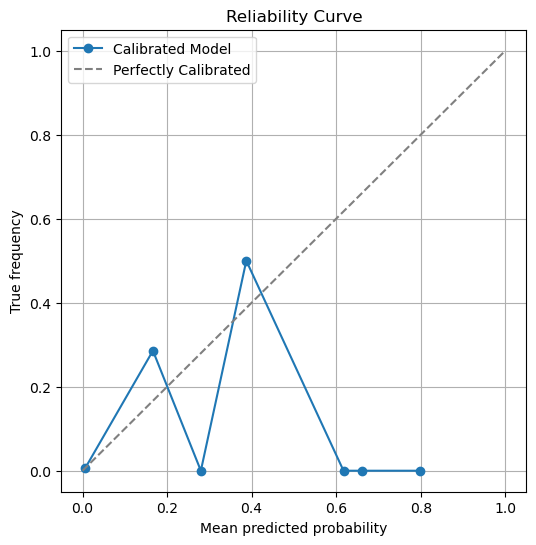

In [94]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_6, n_bins=8, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [95]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_6)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0004


In [99]:
# Calibrated probs for train and test
p_train = cal_model_6.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_6.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
#rare_indices_pct = np.where(p_test > threshold_pct)[0]

print(f"# events > 5× avg: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# events > 5× avg: 571
# events > 99.9 percentile: 27


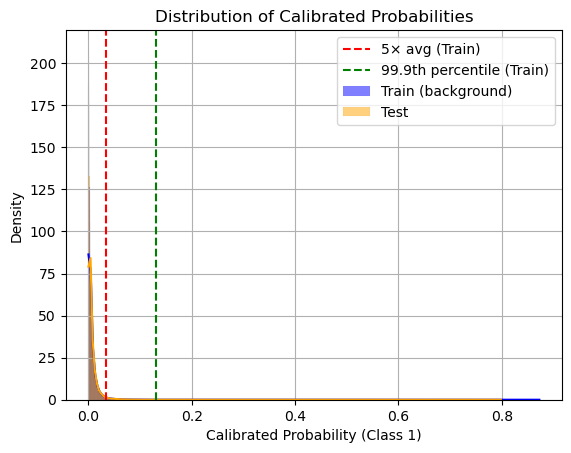

In [100]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


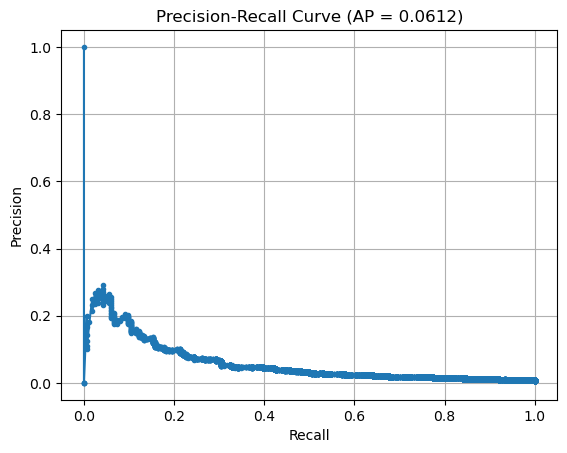

In [101]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


Brier Score: 0.006611490630533237


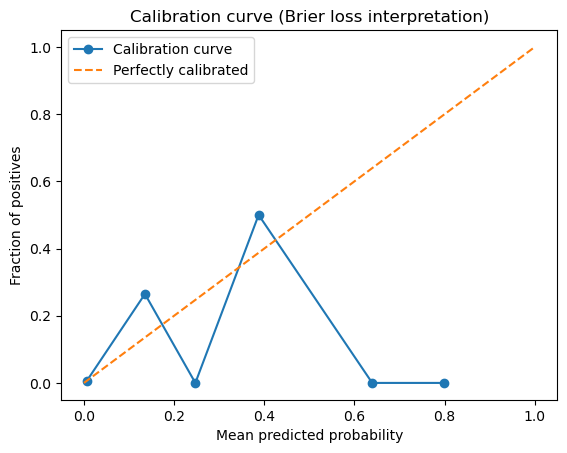

In [102]:
# predicted probabilities and true labels
probs = cal_model_6.predict_proba(X_cal_proc)[:, 1]
y_true = y_cal

# Brier score
print("Brier Score:", brier_score_loss(y_true, probs))

# Calibration curve (can help plot Brier loss behavior)
prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (Brier loss interpretation)')
plt.legend()
plt.show()
